# Evaluate Synthetic Data Quality

## Problem

Gemini has been used to generate some synthetic data ressembling to the training data we have. 
Now, before using it, we need to evaluate the "quality" of the generated data: 
- Does it has the same distribution than the genuine one,
- etc

>__Note:__ Confer to the documentation of this repository to see the prompts and code source used to generate these data.

## Process

We compare the porbability distribution of the data for one single day with the one of the synthetic data for a single day.


## Imports

In [16]:
import os
import json
import math
import pandas as pd
import numpy as np ; np.random.seed(42)
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline 

## Globals

In [17]:
TOP_DATA_DIR = os.path.join(os.getcwd(), "data")
os.makedirs(TOP_DATA_DIR, exist_ok = True)

# genuine 
GENUINE_DATA_DIR = "pcj-raw-data"
GENUINE_DATA_FILENAME = "Data_PCJ_Datanalytix_passage_camions_01_05_2023.csv"

# synthetic 
SYNTHETIC_DATA_DIR = "gemini-generated-data"
# SYNTHETIC_DATA_FILENAME = "synthetic_business_data_20-03-2025.csv" # v2
SYNTHETIC_DATA_FILENAME = "synthetic_business_data_v3_20-03-2025.csv" # v3

# Synthesis
TOP_DATA_DIR, GENUINE_DATA_DIR, GENUINE_DATA_FILENAME

('/home/kla/Workspace/ml/poc-scanning/poc-ia-predict-truck-flow-scanning-systems/notebooks/data',
 'pcj-raw-data',
 'Data_PCJ_Datanalytix_passage_camions_01_05_2023.csv')

## Load data

In [18]:
# genuine 
genuine_data = pd.read_csv(filepath_or_buffer=os.path.join(TOP_DATA_DIR, GENUINE_DATA_DIR, GENUINE_DATA_FILENAME), sep=",")
genuine_data = genuine_data.astype({"Heure Arrivée": "datetime64[ns]", "Heure Départ": "datetime64[ns]"})
genuine_data = genuine_data.sort_values("Heure Arrivée", ascending=True)
genuine_data.head()

,Camion ID,PCJ ID,Heure Arrivée,Heure Départ,Destination,Origine,Categorie
0,289144,1,2023-01-05 05:43:20,2023-01-05 09:27:14,Burkina Faso,Togo,Camion plein
1,152658,1,2023-01-05 05:46:45,2023-01-05 08:22:17,Burkina Faso,Togo,Camion plein
2,454460,1,2023-01-05 05:50:36,2023-01-05 09:35:02,Burkina Faso,Togo,Autocar de 56 Ã 75 places
3,82730,1,2023-01-05 05:52:00,2023-01-05 09:31:55,Burkina Faso,Togo,Camion plein
4,82517,1,2023-01-05 05:52:24,2023-07-05 10:18:41,Burkina Faso,Togo,Camion plein


In [19]:
# synthetic: data are not sorted... 
synthetic_data = pd.read_csv(filepath_or_buffer=os.path.join(TOP_DATA_DIR, SYNTHETIC_DATA_DIR, SYNTHETIC_DATA_FILENAME), sep=",")
synthetic_data = synthetic_data.astype({"Heure Arrivée": "datetime64[ns]", "Heure Départ": "datetime64[ns]"})
synthetic_data = synthetic_data.sort_values("Heure Arrivée", ascending=True)
synthetic_data.head()

,Camion ID,PCJ ID,Heure Arrivée,Heure Départ,Destination,Origine,Categorie
483,4525,1,2025-03-20 05:05:17,2025-03-20 13:58:55,Burkina Faso,Togo,Camion plein
270,4838,1,2025-03-20 05:05:54,2025-03-20 10:32:24,Burkina Faso,Togo,Autocar de 36 à 55 places
184,3210,1,2025-03-20 05:08:23,2025-03-20 12:22:03,Burkina Faso,Togo,Camion plein
591,8403,2,2025-03-20 05:09:23,2025-03-20 15:14:53,Togo,Burkina Faso,Autocar de 15 à 35 places
546,9931,2,2025-03-20 05:10:43,2025-03-20 13:40:17,Togo,Burkina Faso,Camion vide


__Shapes__

In [20]:
genuine_data.shape, synthetic_data.shape

((718, 7), (964, 7))

## Transform and plot to compare

__Genuine__

In [21]:
# merge vehicle categories  
genuine_data = genuine_data.drop(["Camion ID", "PCJ ID", "Heure Départ", "Destination", "Origine"], axis="columns", errors="ignore")
genuine_data = genuine_data.astype({"Categorie": "category"})
genuine_data["Categorie"] = "vehicle"
genuine_data.head()

,Heure Arrivée,Categorie
0,2023-01-05 05:43:20,vehicle
1,2023-01-05 05:46:45,vehicle
2,2023-01-05 05:50:36,vehicle
3,2023-01-05 05:52:00,vehicle
4,2023-01-05 05:52:24,vehicle


In [22]:
# binning: hour
genuine_data = genuine_data.sort_values("Heure Arrivée", ascending=True)
genuine_data.set_index("Heure Arrivée", inplace=True)
genuine_data = genuine_data.resample("1h").count().dropna().reset_index()
genuine_data = genuine_data.rename(columns={"Categorie": "Nb vehicles"})
genuine_data.head()

,Heure Arrivée,Nb vehicles
0,2023-01-05 05:00:00,10
1,2023-01-05 06:00:00,52
2,2023-01-05 07:00:00,90
3,2023-01-05 08:00:00,73
4,2023-01-05 09:00:00,134


__Synthetic__

In [23]:
# merge vehicle categories  
synthetic_data = synthetic_data.drop(["Camion ID", "PCJ ID", "Heure Départ", "Destination", "Origine"], axis="columns", errors="ignore")
synthetic_data = synthetic_data.astype({"Categorie": "category"})
synthetic_data["Categorie"] = "vehicle"
synthetic_data.head()

,Heure Arrivée,Categorie
483,2025-03-20 05:05:17,vehicle
270,2025-03-20 05:05:54,vehicle
184,2025-03-20 05:08:23,vehicle
591,2025-03-20 05:09:23,vehicle
546,2025-03-20 05:10:43,vehicle


In [24]:
# binning: hour
synthetic_data = synthetic_data.sort_values("Heure Arrivée", ascending=True)
synthetic_data.set_index("Heure Arrivée", inplace=True)
synthetic_data = synthetic_data.resample("1h").count().dropna().reset_index()
synthetic_data = synthetic_data.rename(columns={"Categorie": "Nb vehicles"})
synthetic_data.head()

,Heure Arrivée,Nb vehicles
0,2025-03-20 05:00:00,34
1,2025-03-20 06:00:00,29
2,2025-03-20 07:00:00,223
3,2025-03-20 08:00:00,144
4,2025-03-20 09:00:00,149


__Plot genuine__

<Axes: title={'center': 'Genuine data'}, xlabel='Heure Arrivée'>

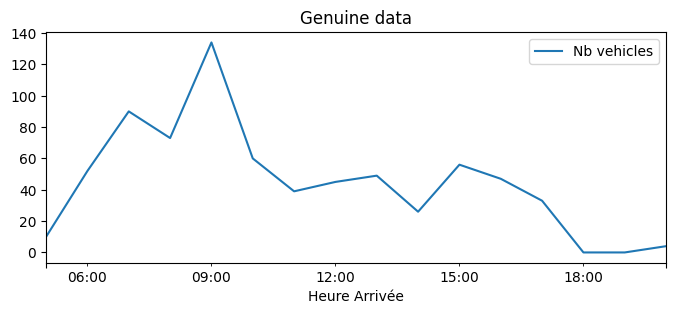

In [25]:
genuine_data.set_index("Heure Arrivée", inplace=True)
genuine_data.plot(title="Genuine data", figsize=(8,3))

__Plot synthetic__

<Axes: title={'center': 'Synthetic data'}, xlabel='Heure Arrivée'>

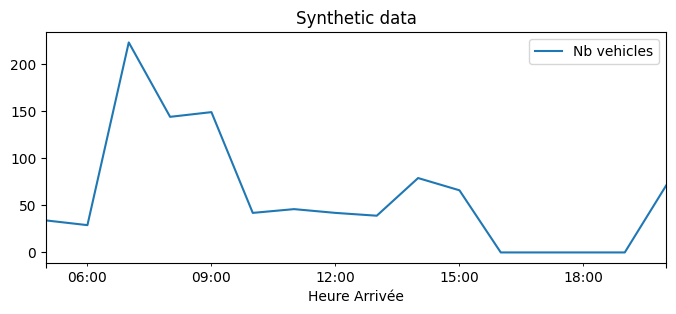

In [26]:
synthetic_data.set_index("Heure Arrivée", inplace=True)
synthetic_data.plot(title="Synthetic data", figsize=(8,3))

__Compare other statistics__ 

In [27]:
genuine_data = genuine_data.reset_index()
genuine_data.describe()

,Heure Arrivée,Nb vehicles
count,16,16.000000
mean,2023-01-05 12:30:00,44.875000
min,2023-01-05 05:00:00,0.000000
25%,2023-01-05 08:45:00,22.000000
50%,2023-01-05 12:30:00,46.000000
75%,2023-01-05 16:15:00,57.000000
max,2023-01-05 20:00:00,134.000000
std,NaN,35.253132


In [29]:
synthetic_data = synthetic_data.reset_index()
synthetic_data.describe()

,Heure Arrivée,Nb vehicles
count,16,16.000000
mean,2025-03-20 12:30:00,60.250000
min,2025-03-20 05:00:00,0.000000
25%,2025-03-20 08:45:00,21.750000
50%,2025-03-20 12:30:00,42.000000
75%,2025-03-20 16:15:00,73.000000
max,2025-03-20 20:00:00,223.000000
std,NaN,62.920585
